### Using transfer learning for image classification

Transfer learning is the process of utilising knowledge from a particular task/domain to model for another task/domain, in our case through the use of pre-trained model.

Luckily for us, Keras has a list of pre-trained models for our implementation. In this project, we will utilise Google’s Inception_V3 model and retrain the last layer of the model to classify our 15 groceries.


In [18]:
# Importing the Keras libraries and packages
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.utils import np_utils
from keras.models import Sequential, load_model
from keras.layers import Input, Convolution2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# Importing other necessary libraries
from sklearn.metrics import classification_report,confusion_matrix
from PIL import Image
import matplotlib.pyplot as plt
import multiprocessing as mp
import numpy as np
import h5py, os, itertools, heapq

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
img_width, img_height = 299, 299 #fixed size for InceptionV3
batch_size = 32

# create the base pre-trained model
inception_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = inception_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(15, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=inception_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in inception_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')


In [3]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [4]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   rotation_range = 40,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

validate_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

training_set = train_datagen.flow_from_directory('./Cloud/Train',
                                                 target_size = (img_width, img_height),
                                                 batch_size = batch_size, 
                                                 class_mode = 'categorical')

validate_set = validate_datagen.flow_from_directory('./Cloud/Validate',
                                                    target_size = (img_width, img_height),
                                                    batch_size = batch_size, 
                                                    class_mode = 'categorical')

Found 28153 images belonging to 15 classes.
Found 7023 images belonging to 15 classes.


In [5]:
# Defining callbacks to save best models on the fly
checkpointer = ModelCheckpoint(filepath='model_inception.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)

filename='model_train_new.csv'
csv_log = CSVLogger(filename, separator=',', append=False)

early_stop = EarlyStopping(monitor='val_loss', patience=10)

In [6]:
# train the model on the new data for a few epochs
hist = model.fit_generator(training_set,
                           steps_per_epoch = (28153//32),
                           epochs = 100,
                           validation_data = validate_set,
                           workers = 4,
                           validation_steps = (7023//32), 
                           callbacks = [csv_log,checkpointer, early_stop])

Epoch 1/100
879/879 [==============================] - 425s 483ms/step - loss: 0.8643 - val_loss: 0.5991

Epoch 00001: val_loss improved from inf to 0.59910, saving model to model_inception.01-0.60.hdf5
Epoch 2/100
879/879 [==============================] - 416s 473ms/step - loss: 0.4873 - val_loss: 0.4925

Epoch 00002: val_loss improved from 0.59910 to 0.49248, saving model to model_inception.02-0.49.hdf5
Epoch 3/100
879/879 [==============================] - 417s 474ms/step - loss: 0.4306 - val_loss: 0.4968

Epoch 00003: val_loss did not improve from 0.49248
Epoch 4/100
879/879 [==============================] - 416s 473ms/step - loss: 0.3992 - val_loss: 0.5201

Epoch 00004: val_loss did not improve from 0.49248
Epoch 5/100
879/879 [==============================] - 418s 476ms/step - loss: 0.3777 - val_loss: 0.4371

Epoch 00005: val_loss improved from 0.49248 to 0.43711, saving model to model_inception.05-0.44.hdf5
Epoch 6/100
879/879 [==============================] - 417s 475ms/ste

In [ ]:
# fine-tuning if needed

# # at this point, the top layers are well trained and we can start fine-tuning
# # convolutional layers from inception V3. We will freeze the bottom N layers
# # and train the remaining top layers.

# # let's visualize layer names and layer indices to see how many layers
# # we should freeze:
# for i, layer in enumerate(base_model.layers):
#    print(i, layer.name)

# # we chose to train the top 2 inception blocks, i.e. we will freeze
# # the first 249 layers and unfreeze the rest:
# for layer in model.layers[:249]:
#    layer.trainable = False
# for layer in model.layers[249:]:
#    layer.trainable = True

# # we need to recompile the model for these modifications to take effect
# # we use SGD with a low learning rate
# from keras.optimizers import SGD
# model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy')

# # we train our model again (this time fine-tuning the top 2 inception blocks
# # alongside the top Dense layers
# model.fit_generator(...)

Text(0.5,1,'Training & Validation Loss')

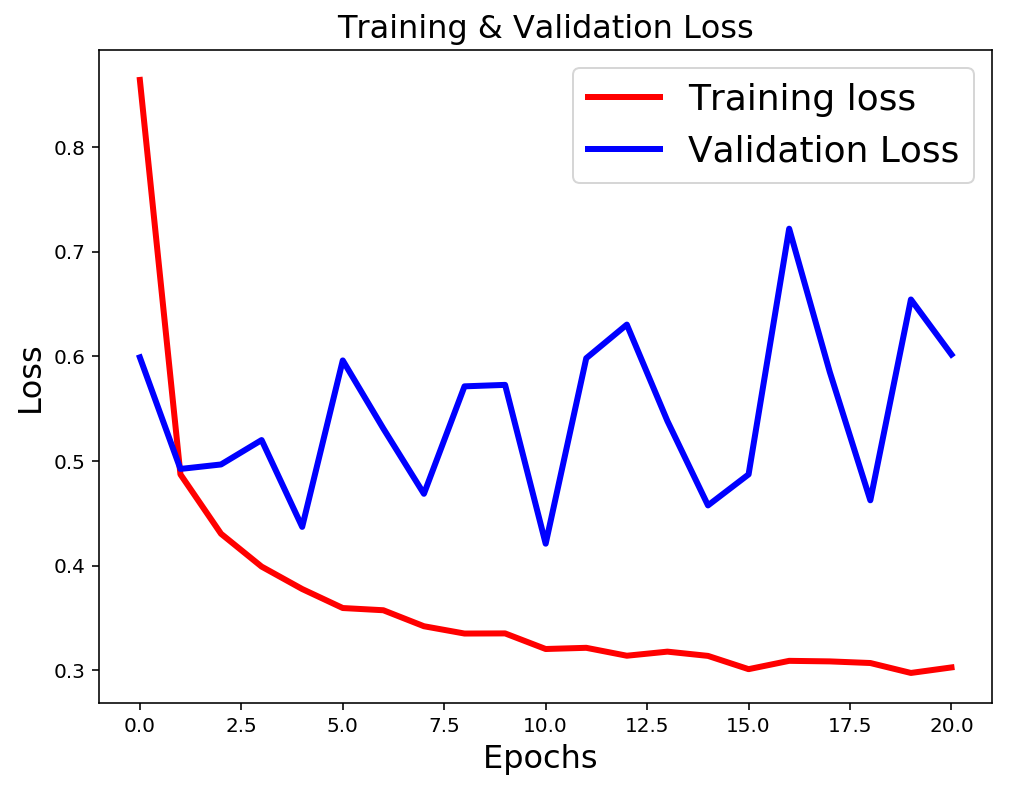

In [10]:
# Visualising loss and accuracy 

# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(hist.history['loss'],'r',linewidth=3.0)
plt.plot(hist.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Training & Validation Loss',fontsize=16)
 
# # Accuracy Curves
# plt.figure(figsize=[8,6])
# plt.plot(hist.history['acc'],'r',linewidth=3.0)
# plt.plot(hist.history['val_acc'],'b',linewidth=3.0)
# plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
# plt.xlabel('Epochs ',fontsize=16)
# plt.ylabel('Accuracy',fontsize=16)
# plt.title('Training & Validation Accuracy',fontsize=16)

In [2]:
from keras.models import load_model

loaded_model = load_model('./Results/model_inception.11-0.42.hdf5')

In [19]:
num_classes = 15
test_dir = './Model/Test/'

test_list=[]

for category in os.listdir(test_dir):
    image_list =os.listdir(test_dir + category)
    print ('Loaded images of dataset-'+'{}'.format(category))
    for img in image_list:
        test_image = load_img(test_dir + category + '/' + img, target_size = (299, 299))
        test_image = img_to_array(test_image)
        test_image = np.expand_dims(test_image, axis = 0)
        test_image = preprocess_input(test_image)
        test_list.append(test_image)

test_data = np.array(test_list)
test_data = test_data.astype('float32')
print (test_data.shape)

Loaded images of dataset-apple
Loaded images of dataset-asparagus
Loaded images of dataset-banana
Loaded images of dataset-broccoli
Loaded images of dataset-cabbage
Loaded images of dataset-capsicums
Loaded images of dataset-cherry
Loaded images of dataset-cherry_tomato
Loaded images of dataset-chilli
Loaded images of dataset-grapes
Loaded images of dataset-mango
Loaded images of dataset-pakchoi
Loaded images of dataset-soursop
Loaded images of dataset-spinach
Loaded images of dataset-strawberry
(1500, 1, 299, 299, 3)


In [20]:
img_count_incat = []
img_count_incat_cumulative = []
for category in os.listdir(test_dir):
    path, dirs, files = next(os.walk(test_dir + category))
    img_count = len(files)
    img_count_incat.append(img_count)
    img_count_incat_cumulative.append(np.sum(img_count_incat))

In [21]:
num_of_samples = test_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')

for i in range(num_classes):
    if i == 0:
        labels[0:img_count_incat_cumulative[i]] = i
    else:
        labels[img_count_incat_cumulative[i-1]:img_count_incat_cumulative[i]] = i

target_names = ['Apple', 'Asparagus', 'Banana', 'Broccoli', 'Cabbage', 
                'Capsicums', 'Cherry', 'Cherry Tomato', 'Chilli', 'Grapes', 
                'Mango', 'Pakchoi', 'Soursop', 'Spinach', 'Strawberry']

# convert class labels to on-hot encoding
Y = np_utils.to_categorical(labels, num_classes)

In [22]:
def predictor(test_data, model):
    predictions = []
    for i in range(len(test_data)):
        result = model.predict(test_data[i])
        predictions.append(int(np.argmax(result, axis=1)))
    
    return predictions

In [23]:
# Plotting the confusion matrix
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
    """
    Function plots a confusion matrix

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 20)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label', fontsize=15)
    plt.xlabel('Predicted label\n\nAccuracy={:0.4f}; Misclass={:0.4f}'.format(accuracy, misclass), fontsize=15)
    plt.show()

In [24]:
true_labels = np.argmax(Y, axis = 1)
predictions = predictor(test_data, loaded_model)

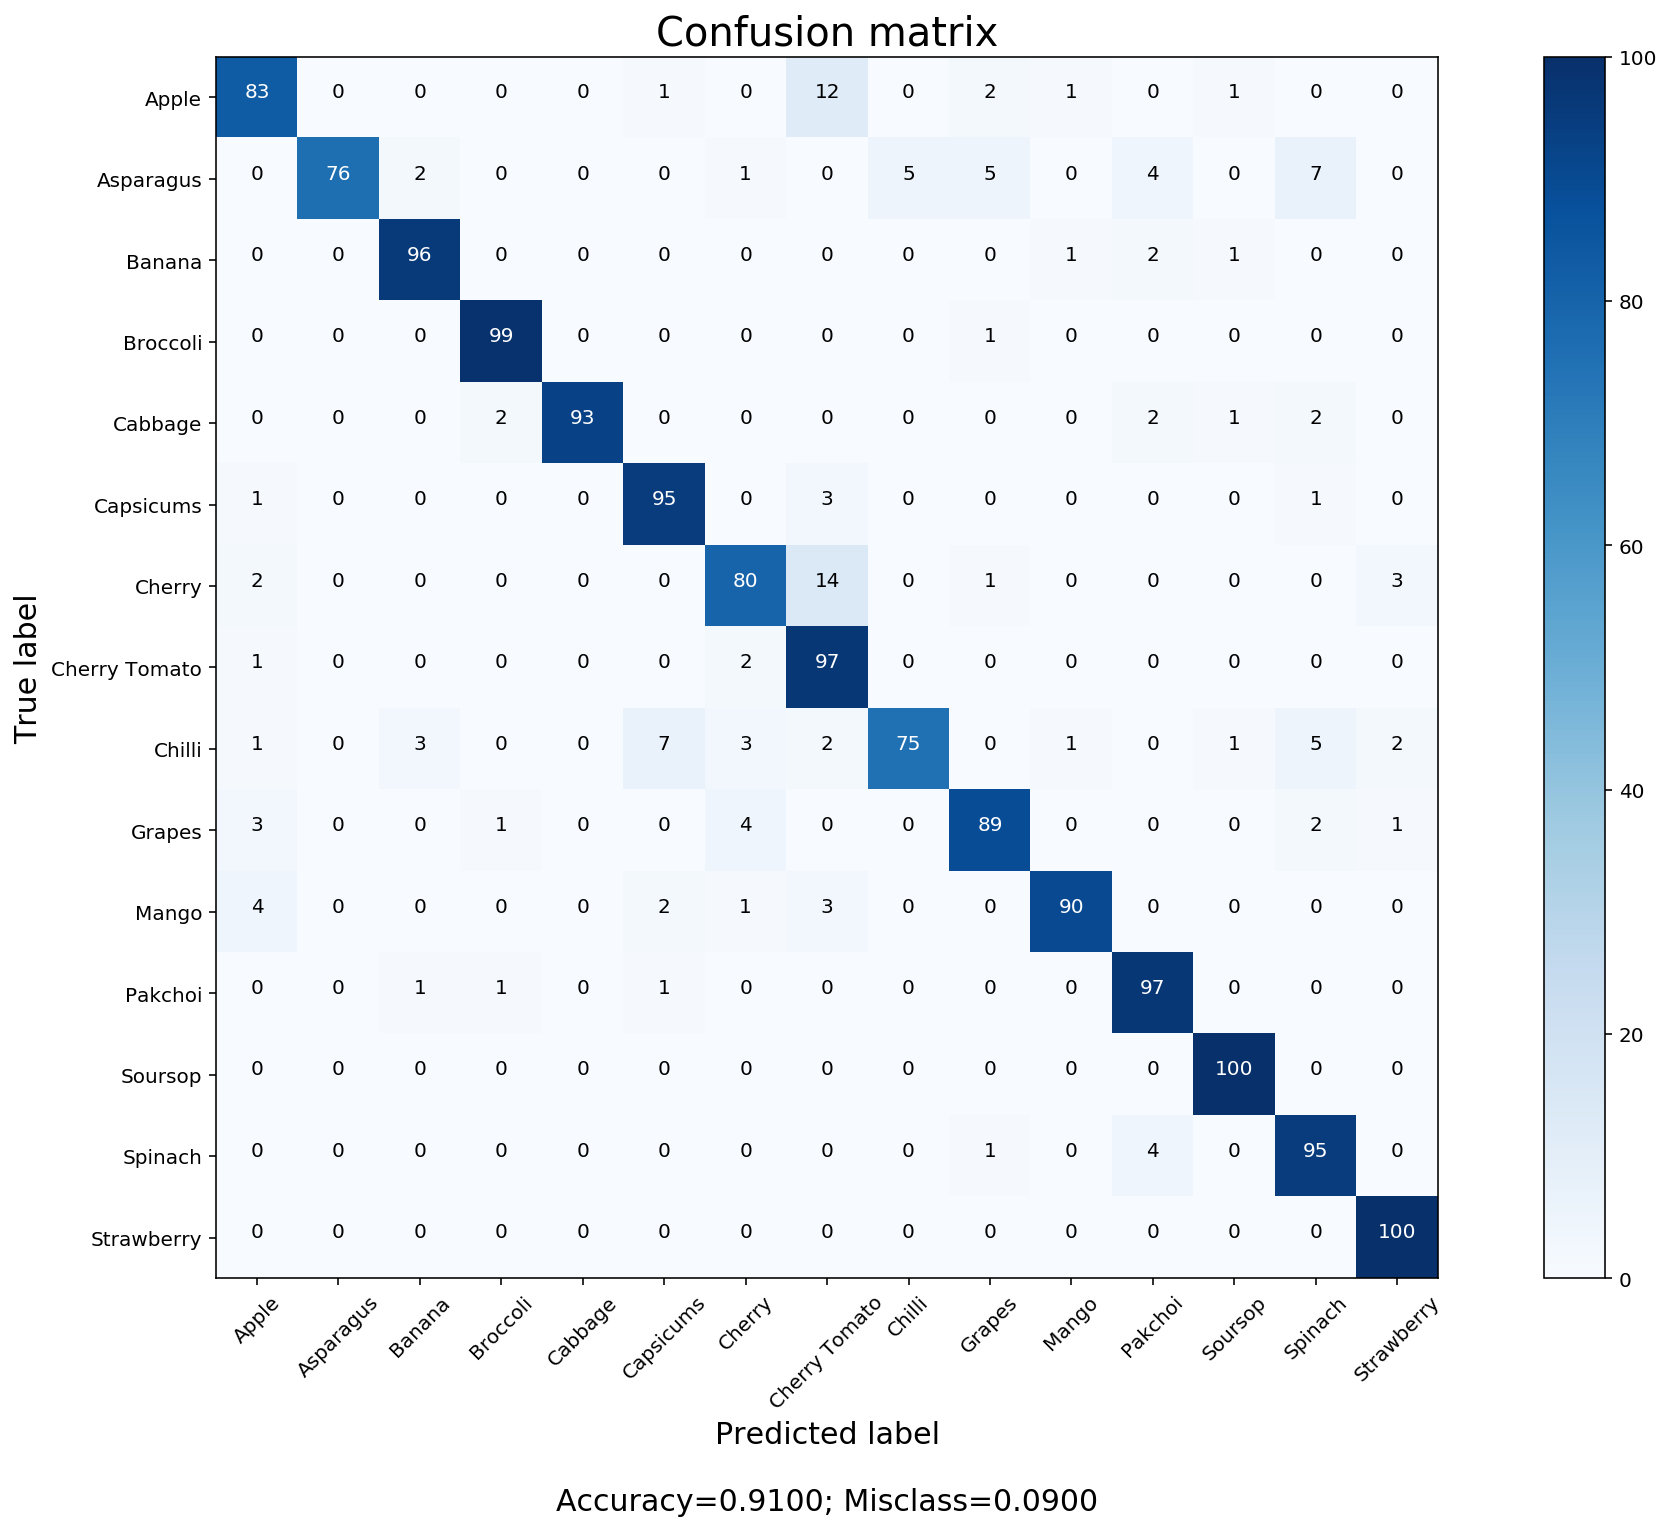

In [25]:
plot_confusion_matrix(confusion_matrix(true_labels, predictions), target_names=target_names)

In [26]:
print(classification_report(true_labels, predictions, target_names=target_names))

               precision    recall  f1-score   support

        Apple       0.87      0.83      0.85       100
    Asparagus       1.00      0.76      0.86       100
       Banana       0.94      0.96      0.95       100
     Broccoli       0.96      0.99      0.98       100
      Cabbage       1.00      0.93      0.96       100
    Capsicums       0.90      0.95      0.92       100
       Cherry       0.88      0.80      0.84       100
Cherry Tomato       0.74      0.97      0.84       100
       Chilli       0.94      0.75      0.83       100
       Grapes       0.90      0.89      0.89       100
        Mango       0.97      0.90      0.93       100
      Pakchoi       0.89      0.97      0.93       100
      Soursop       0.96      1.00      0.98       100
      Spinach       0.85      0.95      0.90       100
   Strawberry       0.94      1.00      0.97       100

  avg / total       0.92      0.91      0.91      1500

